In [111]:
import networkx as nx
import numpy as np
import copy
import time
import matplotlib.pyplot as plt # https://matplotlib.org/stable/plot_types/basic/plot.html


def get_net(net_type, net_order, rng=None):
    if net_type == 'scale_free':
        return nx.barabasi_albert_graph(n=net_order, m=2, seed=rng, initial_graph=nx.complete_graph(3))

    elif net_type == 'complete_mixing':
        return nx.complete_graph(n=net_order)

    elif net_type == 'lattice':
        return nx.grid_2d_graph(int(np.sqrt(net_order)), int(np.sqrt(net_order)), periodic=False)

    else:
        return None


def update_opinions(u, v, opinions, convergence, symmetric_updating=True):
    diff = opinions[u] - opinions[v]

    opinions[u] -= convergence * diff
    
    if symmetric_updating:
        opinions[v] += convergence * diff
        
    return opinions


def effective_neighbors(u, adjG, opinions, threshold):
    
    distances = opinions - opinions[u] # vector of opinion distances
    distances[(distances < -threshold) | (distances > threshold)] = -1 # turn nodes at dist>d into -1
    distances[distances != -1] = 0 # the rest into 0
    distances += 1 # close nodes are now 1 and far away ones are 0
    
    return adjG[u]*distances # filters out non-neighbors with close opinion distance


def update_effective_net(u, v, effective_net, adjG, opinions, threshold, symmetric_updating):
    
    neighbors = effective_neighbors(u, adjG, opinions, threshold)

    effective_net[u]   = neighbors
    effective_net[:,u] = neighbors
        
    if not symmetric_updating:
        return effective_net

    neighbors = effective_neighbors(v, adjG, opinions, threshold)
    
    effective_net[v]   = neighbors
    effective_net[:,v] = neighbors
            
    return effective_net


def simulate_deffuant_model(G: nx.Graph, iterations: int, threshold: float, convergence: float, initial_opinions=None,\
                            symmetric_updating=True, fast_mode=False, rng=np.random.default_rng(42)):
    """
    Simulates the Deffuant model on the given graph.

    Parameters
    ----------
    G : networkx.Graph
        The graph on which to simulate the model.
    iterations : int
        The number of iterations to run the simulation for.
    threshold : float
        Threshold value for node interaction in the model.
    convergence : float
        The value used for updating opinions in the model.
    symmetric_updating: bool
        If True, at every timestep both nodes update their opinions.
        If False, at every timestep only the first selected node updates its opinion.
    fast_mode: bool
        If True, only the last effective network is returned and used throughout the simulation.
        If False, every effective network is saved and returned.

    Returns
    -------
    list[networkx.Graph]
        A list of graphs, where each graph represents the state of the network at a given time step.
    """
    
    # initialize opinions
    if initial_opinions is None:
        opinions = rng.random(G.order())
    else:
        opinions = np.copy(initial_opinions)
    
    # save adjacency matrix
    adjG = nx.to_numpy_array(G)

    # get initial effective network
    effective_net = nx.to_numpy_array(G)
    for u in G.nodes():
        # get 0-1 vector of neighbors at opinion distance <threshold
        neighbors = effective_neighbors(u, adjG, opinions, threshold)
        effective_net[u]   = neighbors
        effective_net[:,u] = neighbors

    if not fast_mode:
        # initialize the list of nets that will be returned
        network_history = [effective_net]
        opinion_history = [opinions]

    # run simulation
    for t in range(1, iterations):
        
        if not fast_mode:
            # copy last effective network
            effective_net = np.copy(network_history[t-1])
            opinions      = np.copy(opinion_history[t-1])

        # choose random node to update
        u = rng.choice(G.order())
        
        # get another node if u is isolated
        while not sum(effective_net[u]):
            u = rng.choice(G.order())
        
        # get a random neighbor of u
        v = rng.choice([i for i in range(G.order()) if effective_net[u,i]==1])

        # update their opinions
        opinions = update_opinions(u, v, opinions, convergence, symmetric_updating)
        
        # we now update the connections of these nodes in the effective network depending on
        # the opinions of their neighbors in the underlying network G
        effective_net = update_effective_net(u, v, effective_net, adjG, opinions, threshold, symmetric_updating)
        
        if not fast_mode:
            # add it to list
            network_history.append(effective_net)
            opinion_history.append(opinions)
    
    if fast_mode:
        return nx.Graph(effective_net), opinions
    else:
        return network_history, opinion_history

In [112]:
# METRIC/PLOT FUNCTIONS

# equation 3 in the paper
def dispersion_index(G):
    return sum([len(cluster)**2 for cluster in nx.connected_components(G)])/(G.order()**2)


# computes the avg value of a metric over a range of d values in a given net type and fixed convergence
def metric_d_data(metric, net_type, net_order, symmetric_updating, iterations,\
                       sample_size, num_points, init_d, final_d, convergence, rng):
    
    # initialize vector with data
    metric_avgs = np.zeros(num_points)
    # initialize vector with x-axis points
    d = [init_d + i*(final_d-init_d)/num_points for i in range(num_points)]
    
    for i in range(num_points):
        print(".", end='') # loading
        
        # at every point we will average the metric over sample_size networks
        for j in range(sample_size):
            
            # generate network sample
            initial_net = get_net(net_type, net_order, rng)

            final_net, _ = simulate_deffuant_model(initial_net, iterations, d[i], convergence,
                                                 symmetric_updating=symmetric_updating, fast_mode=True, rng=rng)
            
            # add metric to data vect so that we can compute the avg
            metric_avgs[i] += metric(final_net)
    
    print()
    # compute avgs
    metric_avgs = metric_avgs/sample_size

    return d, metric_avgs


# computes the avg evolution of a metric in the deffuant model with fixed parameters in a given net type and fixed convergence
def metric_evol_data(metric, net_type, net_order, symmetric_updating,\
                          iterations, sample_size, d, convergence, rng):
    
    # initialize vector with data
    metric_avgs = np.zeros(iterations)
    
    for i in range(sample_size):
        print(".", end='') # loading
        
        # generate network sample
        initial_net = get_net(net_type, net_order, rng)

        nets, = simulate_deffuant_model(initial_net, iterations, d, convergence,\
                                       symmetric_updating=symmetric_updating, fast_mode=False, rng=rng)

        # add metric of every net so that we can compute the avg
        metric_avgs = metric_avgs + np.array([metric(net) for net in nets])
    
    print()
    # compute avgs
    metric_avgs = metric_avgs/sample_size

    return list(range(iterations)), metric_avgs
   

# runs simulation and sets x and y with the initial and final opinions of agents
def opinion_change_data(G, iterations, d, convergence, symmetric_updating, rng):
    
    initial_opinions = rng.random(G.order())
    final_network, final_opinions = simulate_deffuant_model(G, iterations, d, convergence,
                                                            symmetric_updating=symmetric_updating,
                                                            initial_opinions=initial_opinions, fast_mode=True, rng=rng)

    y_bar = np.array([G.degree[node] for node in G.nodes()])
    
    # rescale the bars
    y_bar = y_bar/(4*max(y_bar))
    
    return initial_opinions, final_opinions, y_bar

...............
...............
simulation time: 712.176 seconds


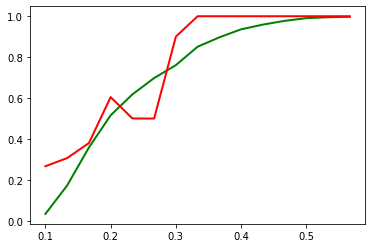

In [118]:
# FIG 2 PAPER
# PLOT METRIC AT DIFFERENT VALUES OF D

rng = np.random.default_rng(42)

start = time.time()

# run simulations
x1, y1 = metric_d_data(metric=dispersion_index, net_type='scale_free', net_order=900, symmetric_updating=False,
                       iterations=10000, sample_size=5, num_points=15, init_d=0.1, final_d=0.6, convergence=0.3, rng=rng)

x2, y2 = metric_d_data(metric=dispersion_index, net_type='complete_mixing', net_order=900, symmetric_updating=True,
                       iterations=10000, sample_size=5, num_points=15, init_d=0.1, final_d=0.6, convergence=0.3, rng=rng)

total_time = round(time.time()-start, 3)
print(f"simulation time: {total_time} seconds")

# generate plot
fig, ax = plt.subplots()
ax.plot(x1, y1, linewidth=2.0, color='green')
ax.plot(x2, y2, linewidth=2.0, color='red')
plt.show()

simulation time: 92.347 seconds


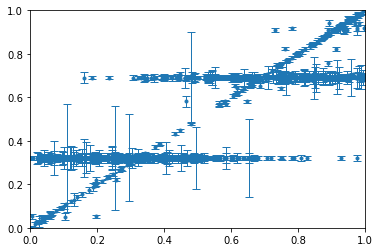

In [117]:
# FIG 4 PAPER
# OPINION CHANGE PLOT (requires many iterations)

# initialize rng and network
rng = np.random.default_rng(42)
net = nx.barabasi_albert_graph(n=900, m=2, seed=rng, initial_graph=nx.complete_graph(3))

start = time.time()

# run simulation
x, y, y_bar = opinion_change_data(G=net, iterations=300000, d=0.2, convergence=0.3, symmetric_updating=False, rng=rng)

total_time = round(time.time()-start, 3)
print(f"simulation time: {total_time} seconds")

# generate plot
fig, ax = plt.subplots()
ax.errorbar(x, y, y_bar, fmt='.', linewidth=1, capsize=4)
ax.set(xlim=(0, 1), ylim=(0, 1))
plt.show()

In [4]:
# we set n=900 in the BA graph so that it has the same amount of vertices as the 30x30 grid graph
# we set m=2 so that the average degree of the graph is 2*|E|/n = 2*(3+2*897)/900 ~= 4 as in the grid graph

BA_graph = nx.barabasi_albert_graph(n=900, m=2, seed=42, initial_graph=nx.complete_graph(3))
lattice  = nx.grid_2d_graph(30, 30, periodic=False, create_using=None)

In [120]:
rng = np.random.default_rng(42)

graph = nx.complete_graph(n=900)
#graph = nx.barabasi_albert_graph(n=900, m=2, seed=42, initial_graph=nx.complete_graph(3))

start = time.time()

effective_networks, _ = simulate_deffuant_model(graph, 10000, 0.3, 0.3, symmetric_updating=True, fast_mode=True, rng=rng)

total_time = round(time.time()-start, 3)
print(f"simulation time: {total_time} seconds")

simulation time: 6.694 seconds


In [26]:
print(nx.__version__)

2.8.8
